# Convolutional Neural Network

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import matplotlib as mpl
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline

import cv2 as cv    # for capturing videos
import math   # for mathematical operations
import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from keras.utils import np_utils
from skimage.transform import resize   # for resizing images
import seaborn as sns
import os

import os
import tempfile

# keras imports for the dataset and building our neural network
from tensorflow import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.utils import np_utils

from keras.preprocessing.image import ImageDataGenerator

import sklearn
# to calculate accuracy
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


In [2]:
# Define some metrics of accuracy
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

The division of the dataset into chunks, the extraction of random frames from those chunks, and the extraction and saving of faces from those frames are presented in a separate notebook.

Let's define some functions which will be useful for visualising our results

In [3]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [57]:
def plot_metrics(history):
  metrics =  ['auc', 'precision', 'recall'] # removed loss
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.5,1])
    else:
      plt.ylim([0,1])
    plt.legend()
    plt.savefig('epoch_history.png', dpi=800)

In [64]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5.5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Real Videos Detected (True Negatives): ', cm[0][0])
  print('Real Videos Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fake Videos Missed (False Negatives): ', cm[1][0])
  print('Fake Videos Detected (True Positives): ', cm[1][1])
  print('Total Fake Videos: ', np.sum(cm[1]))

  plt.savefig('confusion_matrix.png', dpi=800)

In [68]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.plot(100*np.arange(0,1,0.03),100*np.arange(0,1,0.03),'r',linestyle=(0, (1, 1)))
  plt.xlabel('False positives',fontsize=30)
  plt.ylabel('True positives',fontsize=30)

  plt.xticks(fontsize=20)
  plt.yticks(fontsize=20, rotation=90)

  plt.xlim([-0.5,100])
  plt.ylim([0,100.5])
  plt.grid(True)
    
  legend = plt.legend(prop={'size': 60})
  plt.setp(legend.get_title(),fontsize=20)

  ax = plt.gca()
  ax.set_aspect('equal')
    
  plt.savefig('roc_curve.png', dpi=800)

In [7]:
def plot_roc2(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    
  plt.xlabel(r'False positives [%]}')
  plt.ylabel(r'True positives [%]')
  plt.xlim([-0.5,100])
  plt.ylim([70,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

Define our neural network:

In [8]:

model = Sequential()

# convolutional layer -- try (4,4) instead of (3,3)
model.add(Conv2D(75, kernel_size=(4,4), strides=(3,3), padding='same', activation='relu', input_shape=(256, 256, 3)))

# convolutional layer
model.add(Conv2D(50, kernel_size=(3,3), strides=(2,2), padding='same', activation='tanh'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(25, kernel_size=(2,2), strides=(1,1), padding='same', activation='tanh'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# flatten output of conv
model.add(Flatten())

# hidden layer
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.3))

# output layer
model.add(Dense(1, activation='sigmoid'))

In [9]:
# compiling the model
model.compile(loss='binary_crossentropy', metrics=METRICS, optimizer='adam')

Now lets load and inspect the data

In [10]:
TRAIN = 1
VAL = 2
TEST = 3

In [11]:
# define an iterator to retrieve the data
datagen = ImageDataGenerator()

In [12]:
# load and iterate training dataset
train_it = datagen.flow_from_directory('data/aug/segregated_data/MIX_'+str(TRAIN), class_mode='binary', batch_size=64,shuffle=False)
# load and iterate validation dataset
val_it = datagen.flow_from_directory('data/aug/segregated_data/MIX_'+str(VAL), class_mode='binary', batch_size=64,shuffle=False)
# load and iterate test dataset
test_it = datagen.flow_from_directory('data/aug/segregated_data/MIX_'+str(TEST), class_mode='binary', batch_size=64,shuffle=False)

Found 7364 images belonging to 2 classes.
Found 1426 images belonging to 2 classes.
Found 1488 images belonging to 2 classes.


In [13]:
# extract the labels from the iterators for comparison when plotting

n=64

number_of_examples = len(train_it.filenames)
number_of_generator_calls = math.ceil(number_of_examples / (1.0 * n)) 
# 1.0 above is to skip integer division
train_labels = []
for i in range(0,int(number_of_generator_calls)):
    train_labels.extend(np.array(train_it[i][1]))
train_labels=np.asarray(train_labels)

number_of_examples = len(val_it.filenames)
number_of_generator_calls = math.ceil(number_of_examples / (1.0 * n)) 
# 1.0 above is to skip integer division
val_labels = []
for i in range(0,int(number_of_generator_calls)):
    val_labels.extend(np.array(val_it[i][1]))
val_labels=np.asarray(val_labels)
    
number_of_examples = len(test_it.filenames)
number_of_generator_calls = math.ceil(number_of_examples / (1.0 * n)) 
# 1.0 above is to skip integer division
test_labels = []
for i in range(0,int(number_of_generator_calls)):
    test_labels.extend(np.array(test_it[i][1]))
test_labels=np.asarray(test_labels)

Now let's train the model and assess the performance

In [16]:
# train the model for 100 epochs to give a rough idea of how good the model is
history=model.fit(train_it, epochs=100, validation_data=val_it)

Epoch 1/100
116/116 [==============================] - 18s 159ms/step - loss: 0.7294 - tp: 794.6035 - fp: 1047.1034 - tn: 905.9828 - fn: 973.0345 - accuracy: 0.4657 - precision: 0.3744 - recall: 0.3720 - auc: 0.4462 - val_loss: 0.7043 - val_tp: 1990.9565 - val_fp: 2370.7827 - val_tn: 1863.3914 - val_fn: 1904.8695 - val_accuracy: 0.4740 - val_precision: 0.4564 - val_recall: 0.5126 - val_auc: 0.4691
Epoch 2/100
116/116 [==============================] - 18s 159ms/step - loss: 0.6975 - tp: 2375.2932 - fp: 2860.7932 - tn: 3523.5862 - fn: 3762.4312 - accuracy: 0.4704 - precision: 0.4538 - recall: 0.3946 - auc: 0.4665 - val_loss: 0.6812 - val_tp: 2951.7390 - val_fp: 3597.9565 - val_tn: 5018.2173 - val_fn: 5352.0869 - val_accuracy: 0.4710 - val_precision: 0.4502 - val_recall: 0.3549 - val_auc: 0.4654
Epoch 3/100
116/116 [==============================] - 21s 178ms/step - loss: 0.6970 - tp: 4824.6206 - fp: 5160.1206 - tn: 5477.2588 - fn: 5858.8965 - accuracy: 0.4835 - precision: 0.4840 - recal

Epoch 21/100
116/116 [==============================] - 19s 161ms/step - loss: 0.5671 - tp: 48782.4727 - fp: 38820.7852 - tn: 50773.9219 - fn: 41160.0938 - accuracy: 0.5545 - precision: 0.5568 - recall: 0.5424 - auc: 0.5900 - val_loss: 0.3807 - val_tp: 49958.4766 - val_fp: 39384.0859 - val_tn: 52490.0859 - val_fn: 42097.3477 - val_accuracy: 0.5570 - val_precision: 0.5592 - val_recall: 0.5427 - val_auc: 0.5939
Epoch 22/100
116/116 [==============================] - 19s 164ms/step - loss: 0.5727 - tp: 51357.3438 - fp: 39953.1484 - tn: 54003.8008 - fn: 43001.6016 - accuracy: 0.5595 - precision: 0.5624 - recall: 0.5443 - auc: 0.5981 - val_loss: 0.5131 - val_tp: 52632.3047 - val_fp: 40509.2617 - val_tn: 55746.9141 - val_fn: 43831.5234 - val_accuracy: 0.5624 - val_precision: 0.5651 - val_recall: 0.5456 - val_auc: 0.6026
Epoch 23/100
116/116 [==============================] - 20s 176ms/step - loss: 0.5495 - tp: 53846.7422 - fp: 40885.9492 - tn: 57617.8633 - fn: 44767.7578 - accuracy: 0.5655 -

Epoch 41/100
116/116 [==============================] - 19s 160ms/step - loss: 0.1837 - tp: 114242.6172 - fp: 51534.2070 - tn: 125759.0000 - fn: 63803.5156 - accuracy: 0.6754 - precision: 0.6891 - recall: 0.6416 - auc: 0.7725 - val_loss: 1.2105 - val_tp: 116114.9531 - val_fp: 51746.0000 - val_tn: 127768.1719 - val_fn: 64100.8711 - val_accuracy: 0.6780 - val_precision: 0.6917 - val_recall: 0.6443 - val_auc: 0.7758
Epoch 42/100
116/116 [==============================] - 18s 153ms/step - loss: 0.1854 - tp: 118015.7656 - fp: 51871.5703 - tn: 129759.3125 - fn: 64457.3516 - accuracy: 0.6805 - precision: 0.6947 - recall: 0.6468 - auc: 0.7792 - val_loss: 1.0198 - val_tp: 119887.3516 - val_fp: 52101.7812 - val_tn: 131794.3906 - val_fn: 64736.4766 - val_accuracy: 0.6830 - val_precision: 0.6971 - val_recall: 0.6494 - val_auc: 0.7823
Epoch 43/100
116/116 [==============================] - 19s 164ms/step - loss: 0.1807 - tp: 121904.1719 - fp: 52230.9492 - tn: 133694.6875 - fn: 65071.4297 - accuracy

Epoch 61/100
116/116 [==============================] - 18s 154ms/step - loss: 0.1310 - tp: 190773.4062 - fp: 57771.6797 - tn: 206895.3438 - fn: 75677.2422 - accuracy: 0.7487 - precision: 0.7676 - recall: 0.7160 - auc: 0.8593 - val_loss: 1.1676 - val_tp: 192457.2969 - val_fp: 57940.1289 - val_tn: 209214.0469 - val_fn: 75918.5234 - val_accuracy: 0.7500 - val_precision: 0.7686 - val_recall: 0.7171 - val_auc: 0.8606
Epoch 62/100
116/116 [==============================] - 20s 176ms/step - loss: 0.1202 - tp: 194638.4531 - fp: 58022.2578 - tn: 211000.7188 - fn: 76236.8359 - accuracy: 0.7513 - precision: 0.7704 - recall: 0.7186 - auc: 0.8620 - val_loss: 1.1851 - val_tp: 196325.6094 - val_fp: 58176.1758 - val_tn: 213360.0000 - val_fn: 76458.2188 - val_accuracy: 0.7527 - val_precision: 0.7714 - val_recall: 0.7197 - val_auc: 0.8633
Epoch 63/100
116/116 [==============================] - 19s 166ms/step - loss: 0.1420 - tp: 198354.1406 - fp: 58271.8359 - tn: 215281.8594 - fn: 76779.9062 - accuracy

Epoch 81/100
116/116 [==============================] - 19s 163ms/step - loss: 0.0994 - tp: 268530.7500 - fp: 62673.8633 - tn: 289519.0625 - fn: 86187.1719 - accuracy: 0.7894 - precision: 0.8108 - recall: 0.7570 - auc: 0.8979 - val_loss: 2.4787 - val_tp: 270124.3125 - val_fp: 62802.0430 - val_tn: 291992.1250 - val_fn: 86411.5234 - val_accuracy: 0.7902 - val_precision: 0.8114 - val_recall: 0.7576 - val_auc: 0.8986
Epoch 82/100
116/116 [==============================] - 19s 160ms/step - loss: 0.1145 - tp: 272159.4062 - fp: 62875.7500 - tn: 293945.8750 - fn: 86733.3203 - accuracy: 0.7910 - precision: 0.8123 - recall: 0.7583 - auc: 0.8993 - val_loss: 1.9483 - val_tp: 273994.4688 - val_fp: 63019.4766 - val_tn: 296156.6875 - val_fn: 86949.3516 - val_accuracy: 0.7917 - val_precision: 0.8130 - val_recall: 0.7591 - val_auc: 0.8999
Epoch 83/100
116/116 [==============================] - 21s 179ms/step - loss: 0.1122 - tp: 275932.1250 - fp: 63086.9141 - tn: 298204.4688 - fn: 87247.7812 - accuracy

Let's plot the first 100 epochs of training

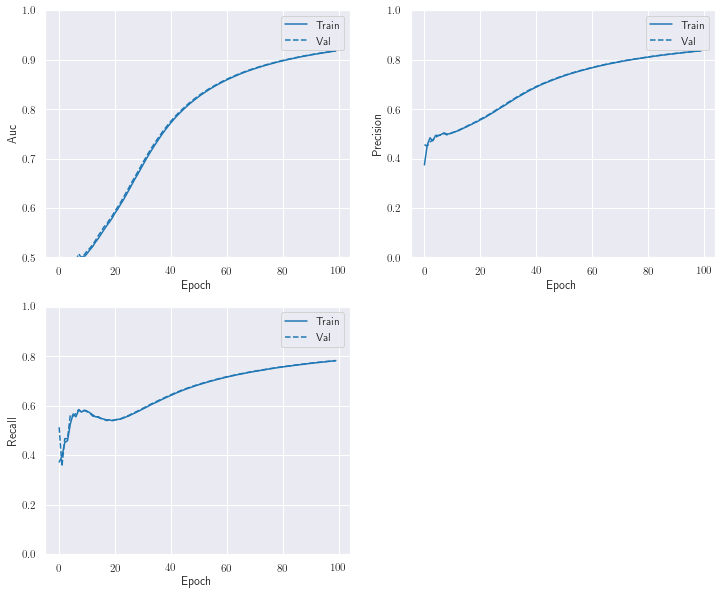

In [58]:
plot_metrics(history)

In [27]:
# most recent compile after 100 epochs
train_predictions_baseline = model.predict(train_it)
test_predictions_baseline = model.predict(test_it)

We now load entirely new data, consisting of another 7368 data points. We will use the above model to predict on this data, as proof that the high accuracy is not a result of overfitting.

In [20]:
# totally new data 
datagen2 = ImageDataGenerator()

In [21]:
test_it2 = datagen.flow_from_directory('data/aug/segregated_data/MIXn', class_mode='binary', batch_size=64,shuffle=False)


Found 7368 images belonging to 2 classes.


We find all metrics appear similar to the performance on the test set of the original data (negligably worse).

In [23]:
model.evaluate(test_it2)

116/116 [==============================] - 17s 149ms/step


[1.395550012588501,
 345879.6875,
 68288.5078125,
 373454.25,
 96609.0546875,
 0.8135145902633667,
 0.8351198434829712,
 0.7816720008850098,
 0.9167481064796448]

(For comparison, the performance on the original test set is below)

In [22]:
model.evaluate(test_it)

24/24 [==============================] - 3s 144ms/step


[0.7621673345565796,
 345131.15625,
 67386.2890625,
 371399.75,
 95880.7890625,
 0.814426600933075,
 0.8366462588310242,
 0.7825891375541687,
 0.9180629253387451]

In [24]:
# let's save this model so we can use it in the future
model.save('blausehen2')

Let's now plot some metrics of accuracy

<Figure size 864x720 with 0 Axes>

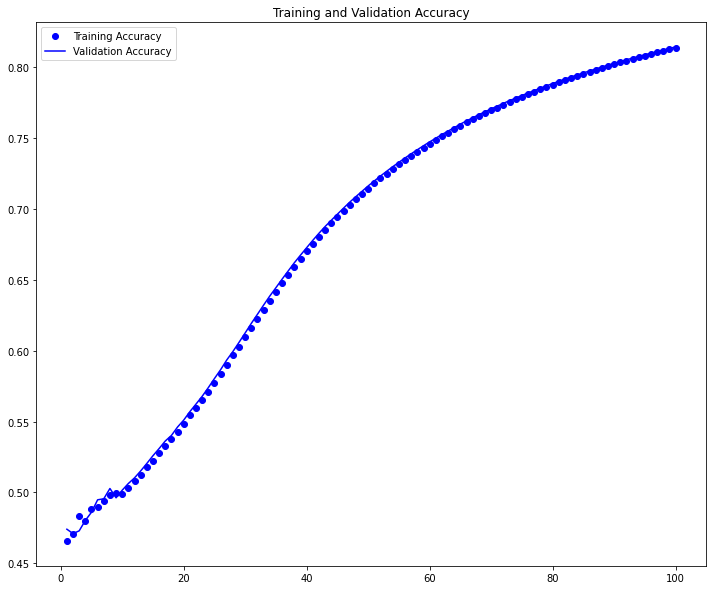

<Figure size 864x720 with 0 Axes>

In [25]:
# plot acc
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1,len(acc) + 1)

plt.plot(epochs,acc,'bo',label = 'Training Accuracy')
plt.plot(epochs,val_acc,'b',label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

loss :  0.7621673345565796
tp :  349836.15625
fp :  69523.2890625
tn :  377488.75
fn :  99245.7890625
accuracy :  0.8116615414619446
precision :  0.8342154622077942
recall :  0.7790029644966125
auc :  0.9140585064888

Real Videos Detected (True Negatives):  593
Real Videos Incorrectly Detected (False Positives):  164
Fake Videos Missed (False Negatives):  181
Fake Videos Detected (True Positives):  550
Total Fake Videos:  731


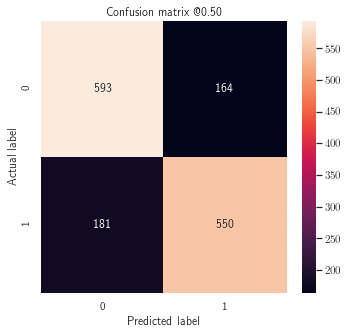

In [65]:
# yeah
baseline_results = model.evaluate(test_it, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

In [30]:
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rc('text', usetex=True)
sns.set()

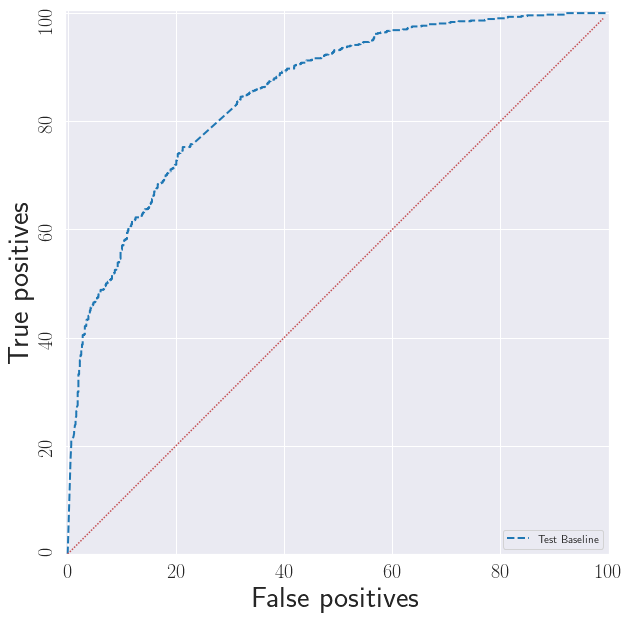

In [69]:
#plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [94]:
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rc('text', usetex=True)
sns.set()

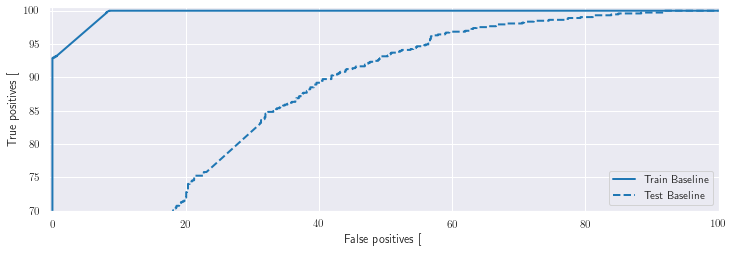

In [70]:
plot_roc2("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc2("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

Now train for many more epochs and see what happens

In [71]:
# train the model for another 15 epochs
history=model.fit(train_it, epochs=15, validation_data=val_it)

Epoch 1/15
116/116 [==============================] - 19s 162ms/step - loss: 0.1047 - tp: 351876.7188 - fp: 69630.3125 - tn: 379457.1250 - fn: 99526.6016 - accuracy: 0.8121 - precision: 0.8348 - recall: 0.7795 - auc: 0.9145 - val_loss: 1.3873 - val_tp: 353787.4375 - val_fp: 69805.0859 - val_tn: 381612.0938 - val_fn: 99709.3906 - val_accuracy: 0.8127 - val_precision: 0.8352 - val_recall: 0.7801 - val_auc: 0.9149
Epoch 2/15
116/116 [==============================] - 17s 147ms/step - loss: 0.0941 - tp: 355856.9688 - fp: 69871.4844 - tn: 383599.9375 - fn: 99977.0547 - accuracy: 0.8132 - precision: 0.8359 - recall: 0.7807 - auc: 0.9153 - val_loss: 1.7929 - val_tp: 357701.1250 - val_fp: 70007.1328 - val_tn: 385792.0312 - val_fn: 100203.6953 - val_accuracy: 0.8137 - val_precision: 0.8363 - val_recall: 0.7812 - val_auc: 0.9157
Epoch 3/15
116/116 [==============================] - 17s 150ms/step - loss: 0.0949 - tp: 359964.9375 - fp: 70071.5469 - tn: 387550.9688 - fn: 100502.8984 - accuracy: 0.

In [72]:
# and now train for a further 20 epochs
history=model.fit(train_it, epochs=20, validation_data=val_it)

Epoch 1/20
116/116 [==============================] - 19s 162ms/step - loss: 0.0867 - tp: 410906.0938 - fp: 72808.3984 - tn: 441922.9688 - fn: 106699.6641 - accuracy: 0.8261 - precision: 0.8495 - recall: 0.7939 - auc: 0.9251 - val_loss: 1.8278 - val_tp: 412707.7500 - val_fp: 72950.0859 - val_tn: 444197.0938 - val_fn: 106909.0859 - val_accuracy: 0.8265 - val_precision: 0.8498 - val_recall: 0.7943 - val_auc: 0.9254
Epoch 2/20
116/116 [==============================] - 17s 150ms/step - loss: 0.0923 - tp: 414763.7812 - fp: 73020.0312 - tn: 446205.0938 - fn: 107165.4375 - accuracy: 0.8269 - precision: 0.8503 - recall: 0.7947 - auc: 0.9257 - val_loss: 1.8987 - val_tp: 416644.0312 - val_fp: 73160.7422 - val_tn: 448368.4375 - val_fn: 107380.7812 - val_accuracy: 0.8273 - val_precision: 0.8506 - val_recall: 0.7951 - val_auc: 0.9260
Epoch 3/20
116/116 [==============================] - 17s 147ms/step - loss: 0.0872 - tp: 418848.8750 - fp: 73218.4922 - tn: 450224.5625 - fn: 107647.2344 - accuracy:

In [73]:
#make the number round haha
history=model.fit(train_it, epochs=2, validation_data=val_it)

Epoch 1/2
116/116 [==============================] - 20s 169ms/step - loss: 0.0853 - tp: 489866.0312 - fp: 76931.7188 - tn: 525493.0625 - fn: 115837.3828 - accuracy: 0.8404 - precision: 0.8643 - recall: 0.8088 - auc: 0.9352 - val_loss: 1.6228 - val_tp: 491742.0000 - val_fp: 77109.3516 - val_tn: 527677.8125 - val_fn: 116034.8281 - val_accuracy: 0.8407 - val_precision: 0.8644 - val_recall: 0.8091 - val_auc: 0.9354
Epoch 2/2
116/116 [==============================] - 18s 158ms/step - loss: 0.0750 - tp: 493850.7500 - fp: 77155.9141 - tn: 529633.5625 - fn: 116318.9844 - accuracy: 0.8410 - precision: 0.8649 - recall: 0.8094 - auc: 0.9356 - val_loss: 1.6946 - val_tp: 495690.3438 - val_fp: 77297.9531 - val_tn: 531871.1875 - val_fn: 116494.4766 - val_accuracy: 0.8413 - val_precision: 0.8651 - val_recall: 0.8097 - val_auc: 0.9358


The accuracy is slowly converging, we do not train any further, but pause to test the performance on both the test set an the extra data we loaded. We find exceptionally high performance.

In [74]:
model.evaluate(test_it)

24/24 [==============================] - 4s 170ms/step


[1.1355875730514526,
 496253.65625,
 77473.3359375,
 532429.6875,
 116655.2890625,
 0.8412440419197083,
 0.8649649620056152,
 0.8096694946289062,
 0.9356709122657776]

In [76]:
model.evaluate(test_it2)

116/116 [==============================] - 16s 137ms/step


[1.1260247230529785,
 500411.875,
 78371.0703125,
 538178.6875,
 117647.75,
 0.8412308692932129,
 0.8645938634872437,
 0.8096519112586975,
 0.9353524446487427]

In [77]:
# save our personal best
model.save('blausehen22')

In summary,

In [82]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 86, 86, 75)        3675      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 43, 43, 50)        33800     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 50)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 21, 21, 50)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 25)        5025      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 25)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 10, 25)       

Load pretrained model -- EfficientNet is highly spoken of in the literature -- and compare

In [78]:
pip install -U efficientnet

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: efficientnet in /usr4/cs542sp/jingham/.local/lib/python3.6/site-packages (1.1.0)
You should consider upgrading via the '/share/pkg.7/python3/3.6.10/install/bin/python3.6 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [79]:
import efficientnet
import efficientnet.keras as efn 

In [91]:
efficient_net = efn.EfficientNetB0(
    weights='imagenet',
    input_shape=(256,256,3),
    include_top=False,
    pooling='max'
)

16809984/16804768 [==============================] - 2s 0us/step


In [92]:
model2 = Sequential()
model2.add(efficient_net)
model2.add(Dense(units = 30, activation='relu'))
model2.add(Dense(units = 30, activation = 'relu'))
model2.add(Dense(units = 1, activation='sigmoid'))
model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 1280)              4049564   
_________________________________________________________________
dense_10 (Dense)             (None, 30)                38430     
_________________________________________________________________
dense_11 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 31        
Total params: 4,088,955
Trainable params: 4,046,939
Non-trainable params: 42,016
_________________________________________________________________


In [93]:
# compiling the sequential model
model2.compile(loss='binary_crossentropy', metrics=METRICS, optimizer='adam')

Ultimately the results are not impressive -- we will play around with this in the future.

In [ ]:
history2=model2.fit(train_it, epochs=15, validation_data=val_it)

Epoch 1/15
116/116 [==============================] - 93s 800ms/step - loss: 0.8119 - tp: 502099.1875 - fp: 79769.3516 - tn: 539642.6250 - fn: 120435.1641 - accuracy: 0.8388 - precision: 0.8629 - recall: 0.8065 - auc: 0.9333 - val_loss: 0.6964 - val_tp: 502473.0312 - val_fp: 80343.6953 - val_tn: 541338.5000 - val_fn: 122208.7812 - val_accuracy: 0.8375 - val_precision: 0.8621 - val_recall: 0.8044 - val_auc: 0.9326
Epoch 2/15
116/116 [==============================] - 65s 558ms/step - loss: 0.7009 - tp: 502661.6562 - fp: 80654.7344 - tn: 543173.4375 - fn: 124268.0859 - accuracy: 0.8362 - precision: 0.8617 - recall: 0.8018 - auc: 0.9319 - val_loss: 0.7027 - val_tp: 502812.4375 - val_fp: 80871.0000 - val_tn: 545193.1875 - val_fn: 126277.3906 - val_accuracy: 0.8350 - val_precision: 0.8614 - val_recall: 0.7993 - val_auc: 0.9312
Epoch 3/15
116/116 [==============================] - 65s 559ms/step - loss: 0.6935 - tp: 503300.2812 - fp: 81393.9453 - tn: 546697.8750 - fn: 128125.4141 - accuracy:

In [ ]:
plot_metrics(history2)

In [ ]:
model3 = Sequential()
model3.add(efficient_net)
model3.add(Conv2D(50, kernel_size=(2,2), strides=(2,2), padding='same', activation='tanh'))
model3.add(Dropout(0.25))
model3.add(Conv2D(25, kernel_size=(2,2), strides=(1,1), padding='same', activation='tanh'))
model3.add(Dense(units = 1, activation='sigmoid'))
model3.summary()

In [ ]:
# compiling the sequential model
model2.compile(loss='binary_crossentropy', metrics=METRICS, optimizer='nadam')

In [ ]:
history3=model3.fit(train_it, epochs=10, validation_data=val_it)

In [ ]:
train_predictions_baseline2 = model2.predict(train_it, batch_size=45)
test_predictions_baseline2 = model2.predict(train_it, batch_size=45)

In [ ]:
# plot various metrics

In [ ]:
baseline_results2 = model2.evaluate(test_it,
                                  batch_size=45, verbose=0)
for name, value in zip(model2.metrics_names, baseline_results2):
  print(name, ': ', value)
print()

plot_cm(test_it, test_predictions_baseline2)

In [ ]:
plot_roc("Train Baseline", Y1, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", Y3, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [ ]:
baseline_results2 = model2.evaluate(test_it,
                                  batch_size=45, verbose=0)
for name, value in zip(model.metrics_names, baseline_results2):
  print(name, ': ', value)
print()

plot_cm(Y3, test_predictions_baseline2)# plot various metrics

plot_metrics(history)

baseline_results = model.evaluate(test_it,
                                  batch_size=45, verbose=0)
for name, value in zip(model.metrics_names, baseline_results2):
  print(name, ': ', value)
print()

plot_cm(test_it, test_predictions_baseline)

plot_roc("Train Baseline", Y1, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", Y3, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')